In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
import os

from scipy import optimize
from sksurv.nonparametric import kaplan_meier_estimator
from itertools import product
import matplotlib as mpl

import noctiluca as nl
import time
from tqdm.auto import tqdm
from multiprocessing import Pool

In [2]:
import matplotlib as mpl
import matplotlib.colors as mplc

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = "sans-serif"
# mpl.rcParams['font.sans-serif'] = "Arial" # might not be available
mpl.rcParams['font.size'] = 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.pad'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.pad'] = 0.5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 3
mpl.rcParams['legend.handletextpad'] = 0.4
mpl.rcParams['legend.columnspacing'] = 1.0
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['figure.subplot.top'] = 0.75
mpl.rcParams['figure.subplot.bottom'] = 0.25
mpl.rcParams['figure.subplot.left'] = 0.25
mpl.rcParams['figure.subplot.right'] = 0.75

In [3]:
colors = {
    'blue'    : '#0077BB',
    'cyan'    : '#33BBEE',
    'teal'    : '#009988',
    'orange'  : '#EE7733',
    'red'     : '#CC3311',
    'magenta' : '#EE3377',
    'grey'    : '#BBBBBB',
}

# Load data

In [4]:
fpt_df = pd.read_csv('06_simulations/first_passage_times.csv', index_col=0)
fpt_df.head()

,target_distance,target_size,fpt,alpha,index,status
0,3.464102,1.732051,100000000.0,0.6,559.0,False
1,3.464102,2.179784,1337551.0,0.6,559.0,True
2,3.464102,2.743256,5.0,0.6,559.0,True
3,3.464102,3.452385,5.0,0.6,559.0,True
4,3.464102,4.344823,0.0,0.6,559.0,True


In [5]:
target_sizes = np.unique(fpt_df["target_size"])
target_sizes

array([1.73205081, 2.17978412, 2.74325603, 3.45238484, 4.3448227 ,
       5.4679548 , 6.88141538, 8.66025404])

In [6]:
target_distances = np.unique(fpt_df["target_distance"])
target_distances

array([ 3.46410162,  3.92054081,  4.43712165,  5.02176855,  5.68345006,
        6.43231649,  7.27985554,  8.23906858,  9.32467006, 10.55331327,
       11.94384577, 13.51759851, 15.29871307, 17.314512  , 19.59591794])

In [7]:
alphas = np.unique(fpt_df["alpha"])
print(alphas)

[0.2 0.3 0.4 0.5 0.6]


# Calculate and plot survival curves
Note: Kaplan-Meier estimation is a bit unnecessary here, since all the trajectories are truncated at the same time (length of the simulations). Still good practice, probably.

In [8]:
# calculate survival curves
survival_curves = {}

for i, (ts, td) in tqdm(enumerate(product(target_sizes, target_distances))):
    curr_df = fpt_df[(fpt_df["target_size"] == ts) & (fpt_df["target_distance"] == td)]
    for alpha in alphas:
        time_km, survival_prob, conf_int = kaplan_meier_estimator(
                curr_df.loc[curr_df["alpha"] == alpha, "status"], 
            curr_df.loc[curr_df["alpha"] == alpha, "fpt"], conf_type="log-log"
            )
        
        survival_curves[(td, ts, alpha)] = [time_km, survival_prob, conf_int]

0it [00:00, ?it/s]

In [9]:
survival_medians = {}
for i, alpha in enumerate(alphas):
    for ts, td in product(target_sizes, target_distances):
        time_km, survival_prob, conf_int = survival_curves[(td, ts, alpha)]
        ind = np.nonzero(survival_prob < 0.5)[0]
        if len(ind) == 0:
            survival_medians[(td, ts, alpha)] = np.nan
        else:
            survival_medians[(td, ts, alpha)] = time_km[ind[0]]

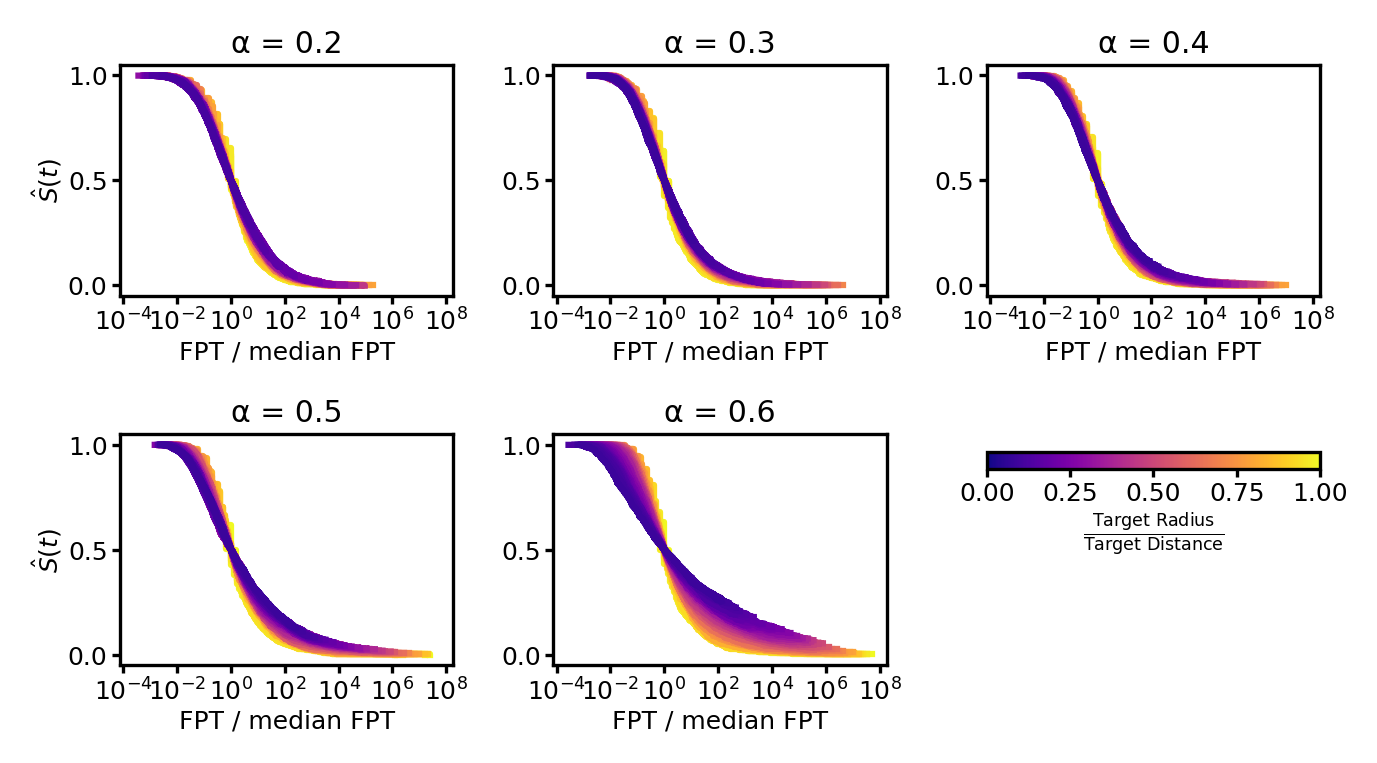

In [10]:
fig, axs = plt.subplots(2, 3, 
                        figsize=(8, 4),
                        sharey=True, sharex=True,
                        gridspec_kw={'hspace' : 0.6, 'wspace' : 0.3},
                       )

axs = axs.flatten()

cm = plt.cm.plasma
sorted_ts_td = sorted(list(product(target_sizes, target_distances)), key=lambda tup: tup[0] / tup[1])

for i, alpha in enumerate(alphas):
    for ts, td in reversed(sorted_ts_td):

        if ts/td >= 1:
            continue
        
        time_km, survival_prob, conf_int = survival_curves.get((td, ts, alpha), [[], [], []])        
        
        # rescaled_time = time_km / (td**(2 / alpha))
        rescaled_time = time_km / survival_medians[(td, ts, alpha)]
        # rescaled_time = time_km

        axs[i].step(rescaled_time, survival_prob, where="post", 
                    label=f"{ts:.2f} / {td:.2f}",
                    color=cm(ts/td),
                    # linewidth=1,
                   )
#         axs[i].fill_between(rescaled_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

    axs[i].set_xlabel(r"FPT / median FPT")
    axs[i].set_title(f"α = {alpha}")
    axs[i].set_xscale("log")
    axs[i].set_xticks([1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8])
    axs[i].xaxis.set_tick_params(labelbottom=True)
    # axs[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axs[i].yaxis.set_tick_params(labelleft=True)
    
axs[0].set_ylabel(r"$\hat{S}(t)$")
axs[3].set_ylabel(r"$\hat{S}(t)$")
    
norm = mpl.colors.Normalize(vmin=0, vmax=1)
bar = plt.colorbar(ax=axs[-1],
                   mappable=mpl.cm.ScalarMappable(norm=norm, cmap=cm),
                   label=r"$\frac{\mathrm{Target\ Radius}}{\mathrm{Target\ Distance}}$",
                   location='top',
                   )
bar.ax.xaxis.set_label_position('bottom')
bar.ax.xaxis.set_ticks_position('bottom')
axs[-1].axis('off')

# plt.savefig('FPT_distributions.pdf')
plt.show()

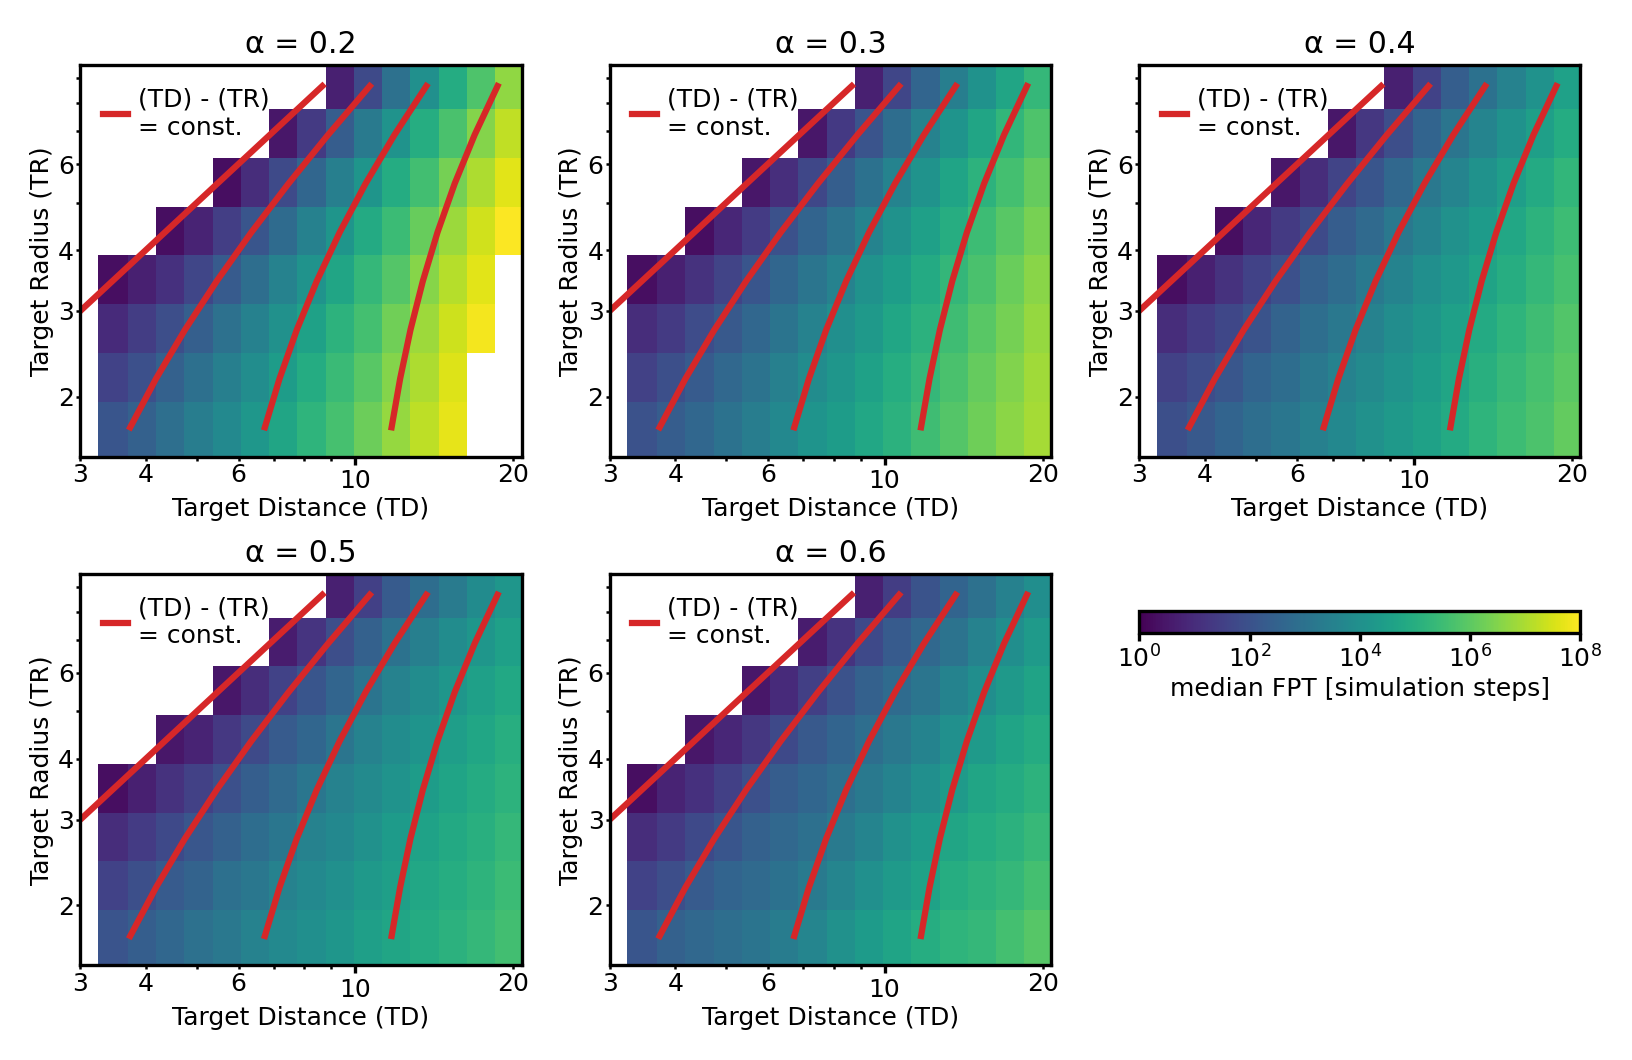

In [11]:
fig, axs = plt.subplots(2, 3, figsize=[10, 6],
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace' : 0.3},
                       )

norm = mpl.colors.LogNorm(vmin=1, vmax=1e8)

for ax, alpha in zip(axs.flatten(), [0.2, 0.3, 0.4, 0.5, 0.6]):
    C = np.zeros((len(target_sizes), len(target_distances)))
    
    for (i, ts), (j, td) in product(list(enumerate(target_sizes)),
                                    list(enumerate(target_distances)),
                                   ):
        C[i, j] = survival_medians[(td, ts, alpha)]
        # C[i, j] = survival_medians[(td, ts, alpha)] / (td-ts)**(2/alpha)
    
    ax.pcolormesh(target_distances, target_sizes, C,
                  shading='nearest',
                  norm=norm,
                 )

    for X in [0, 2, 5, 10]:
        ax.plot(target_sizes+X, target_sizes, color='tab:red')
    
    ax.plot(0, 0, color='tab:red', label='(TD) - (TR)\n= const.')
    ax.legend(handlelength=1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Target Distance (TD)')
    ax.set_ylabel('Target Radius (TR)')
    ax.xaxis.set_minor_formatter('{x:.0f}')
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.yaxis.set_minor_formatter('{x:.0f}')
    ax.yaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_tick_params(which='minor', labelbottom=True)
    ax.xaxis.set_tick_params(which='major', labelbottom=True)
    ax.yaxis.set_tick_params(which='minor', labelleft=True)
    ax.yaxis.set_tick_params(which='major', labelleft=True)
    ax.set_xticks(np.arange(3, 10).tolist()+[20], ['3', '4', '', '6', '', '', '', '20'], minor=True)
    ax.set_yticks(np.arange(2, 10).tolist(), ['2', '3', '4', '', '6', '', '', ''], minor=True)
    ax.set_title(f'α = {alpha}')
    ax.set_xlim([3, None])

ax = axs[-1, -1]
bar = plt.colorbar(ax=ax,
                   mappable=mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),
                   label='median FPT [simulation steps]',
                   location='top',
                   )
bar.ax.xaxis.set_label_position('bottom')
bar.ax.xaxis.set_ticks_position('bottom')
ax.axis('off')

# plt.savefig('FPT_medians.pdf')
plt.show()

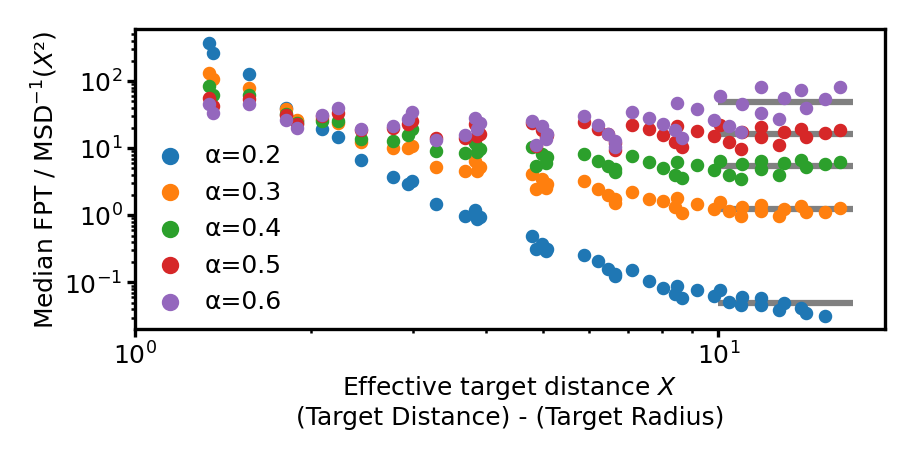

In [12]:
d = 3 # space dimension of the FPT simulations

fig = plt.figure(figsize=[5, 2])
qs = []
for i, alpha in enumerate(alphas):
    color = plt.cm.tab10(i)

    converged_medians = []
    for ts, td in product(target_sizes, target_distances):
        x_eff = td - ts
        if x_eff < 1 or ts < 3:
            continue

        tau_scaling = (x_eff**2 / d)**(1/alpha) # simulations have Γ = 1, so X² = MSD(Δt) = d*Δt^α
        
        plt.scatter(x_eff,
                    survival_medians[(td, ts, alpha)] / tau_scaling,
                    s=5,
                    color=color,
                   )

        if x_eff >= 10:
            converged_medians.append(survival_medians[(td, ts, alpha)] / tau_scaling)

    qs.append(np.nanmean(converged_medians))
    plt.hlines(qs[-1], 10, 17, color='gray', zorder=0)

    plt.scatter(0, 0, color=color, label=f'α={alpha}', s=10)
qs = np.array(qs)

plt.legend(loc=(0.0, 0.02))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Effective target distance $X$\n(Target Distance) - (Target Radius)')
plt.ylabel(r'Median FPT / $\mathrm{MSD}^{-1}(X²)$')
plt.xlim([1, None])
# plt.ylim([None, 3e1])

# plt.savefig('FPT_median_vs_X.pdf')
plt.show()

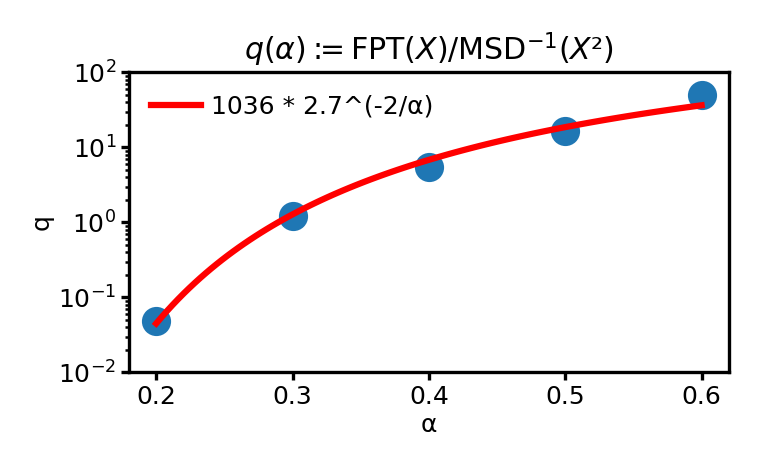

In [13]:
plt.figure(figsize=[4, 2])
plt.plot(alphas, qs, marker='o', linestyle='')

popt, _ = optimize.curve_fit(lambda x, a, b: a + b*x,
                             -2/alphas, np.log(qs),
                            )
a, b = np.exp(popt)

aplot = np.linspace(0.2, 0.6, 100)
plt.plot(aplot, a*b**(-2/aplot),
         color='r',
         label=f'{a:.0f} * {b:.1f}^(-2/α)',
        )

plt.legend()
plt.yscale('log')
plt.yticks(np.logspace(-2, 2, 5))
plt.title(r'$q(\alpha) :\!\!\!= \mathrm{FPT}(X) / \mathrm{MSD}^{-1}(X²)$')
plt.xlabel('α')
plt.ylabel('q')

# plt.savefig('FPT_q-alpha.pdf')
plt.show()

In [14]:
# MSD matching
a0 = 0.294              # from our U2OS fit
G0 = np.exp(-5.823)/a0  # 
a1 = 0.5                # from Rouse fit to SRLCI
G1 = 0.0024             # data in (Gabriele 2022)

tau = (G0/G1)**(1/(a1-a0))
M = np.sqrt(G0*tau**a0) * 1e3 # nm

print(tau)
print(M)

1052.110742884301
279.0107809109491


In [15]:
# Conversion bp <--> nm
# We use two fixed points: nucleosome @ 200bp, 11nm and Fbn2 C65 (ΔCTCFsites) @ 505kb, 547nm
s = (200, 5.05e5) # bp
r = (11, 547)     # nm
nu = np.log(r[0]/r[1])/np.log(s[0]/s[1])
G  = r[0]/s[0]**nu
print(nu, G)

0.49866675439002817 0.783331381586804


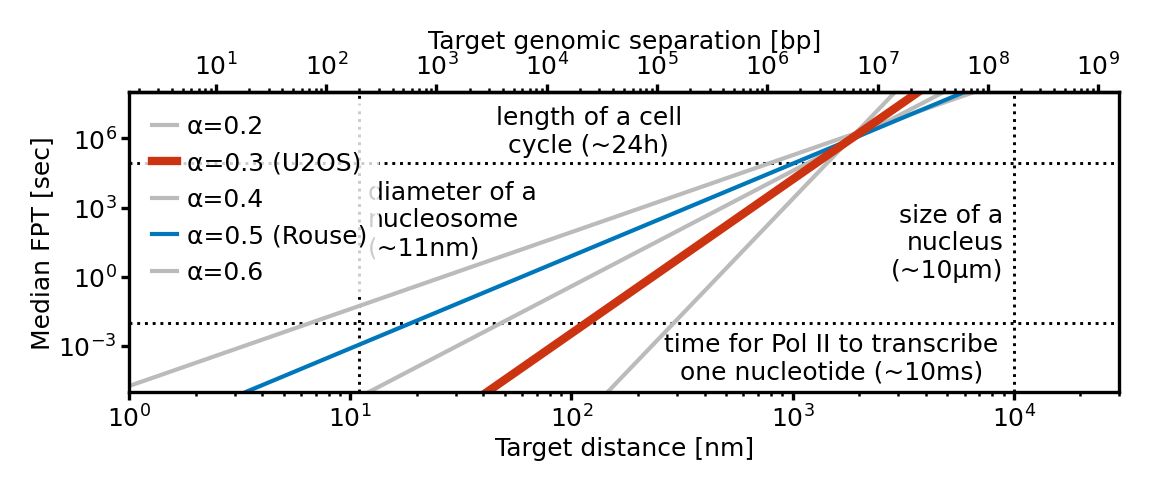

In [16]:
fig = plt.figure(figsize=[6.6, 2])

def kb2nm(x): return G*x**nu
def nm2kb(x): return (x/G)**(1/nu)
ax = plt.gca()
ax2 = ax.secondary_xaxis('top', functions=(nm2kb, kb2nm))

xplot = np.logspace(-1, 6, 100) # nm
for alpha, q in zip(alphas, qs):
    kwargs = dict(color=colors['grey'], label=f'α={alpha}', zorder=0, linewidth=1)
    if alpha == 0.3:
        kwargs['color'] = colors['red']
        kwargs['zorder'] = 2
        kwargs['label'] += ' (U2OS)'
        kwargs['linewidth'] = 2
    elif alpha == 0.5:
        kwargs['color'] = colors['blue']
        kwargs['zorder'] = 1
        kwargs['label'] += ' (Rouse)'
        
    fpt = q*tau*(xplot/(np.sqrt(2*3)*M))**(2/alpha) # M² --> 2*3*M² for two loci in 3D
    plt.plot(xplot, fpt, **kwargs)

lines_kwargs = dict(color='k', linestyle=':', linewidth=0.7, zorder=-1)
plt.axvline(1e4, **lines_kwargs)
plt.text(9e3, 3e1, "size of a\nnucleus\n(~10μm)",
         ha='right', va='center',
        )

plt.axvline(1.1e1, **lines_kwargs)
plt.text(1.2e1, 3e2, "diameter of a\nnucleosome\n(~11nm)",
         ha='left', va='center',
        )

plt.axhline(24*60*60, **lines_kwargs)
plt.text(1.2e2, 1.5e5, "length of a cell\ncycle (~24h)",
         ha='center', va='bottom',
        )

plt.axhline(1e-2, **lines_kwargs)
plt.text(1.5e3, 4e-3, "time for Pol II to transcribe\none nucleotide (~10ms)",
         ha='center', va='top',
        )

plt.xscale('log')
plt.yscale('log')

plt.yticks(np.logspace(-21, 21, 15))
ax2.set_xticks(np.logspace(0, 10, 11)) # seems to be unnecessary with matplotlib 3.10 (before: 3.5)
plt.xlim([1, 3e4])
plt.ylim([1e-5, 1e8])

plt.legend(loc='upper left', frameon=True, edgecolor=(1., 1., 1., 0), handlelength=1)
plt.xlabel('Target distance [nm]')
plt.ylabel('Median FPT [sec]')
ax2.set_xlabel('Target genomic separation [bp]')

# plt.savefig('FPT_panel_bp-on-top.pdf')
plt.show()

In [17]:
# Converting median FPT (s) to target distance (nm)
ia = 1
t = np.array([0.1, 10, 1000])
print("alpha =", alphas[ia])
(t/tau/qs[ia])**(alphas[ia]/2) * (np.sqrt(2*3)*M)

alpha = 0.3


array([165.16516077, 329.54782104, 657.5343483 ])

In [18]:
# Converting target distance (nm) to median FPT (s)
ia = 1
x = np.array([100, 200, 500, 1000])
print("alpha =", alphas[ia])
print(qs[ia]*tau*(x/(np.sqrt(2*3)*M))**(2/alphas[ia]))

alpha = 0.3
[3.52541599e-03 3.58159940e-01 1.61068420e+02 1.63635315e+04]
